Epoch 1/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6329 - loss: 1.3183 - val_accuracy: 0.7206 - val_loss: 0.9855
Epoch 2/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7376 - loss: 0.9188 - val_accuracy: 0.7363 - val_loss: 0.7808
Epoch 3/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7572 - loss: 0.7408 - val_accuracy: 0.7444 - val_loss: 0.6635
Epoch 4/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - loss: 0.6492 - val_accuracy: 0.7632 - val_loss: 0.5960
Epoch 5/5
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.5788 - val_accuracy: 0.7754 - val_loss: 0.5584
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
Train AUC: 0.8752, Train Gini: 0.7504
Test AUC: 0.8634, Test Gini: 0.7268
Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5960 - loss: 1.3703 - val_accuracy: 0.7236 - val_loss: 1.0873
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7445 - loss: 1.0161 - val_accur

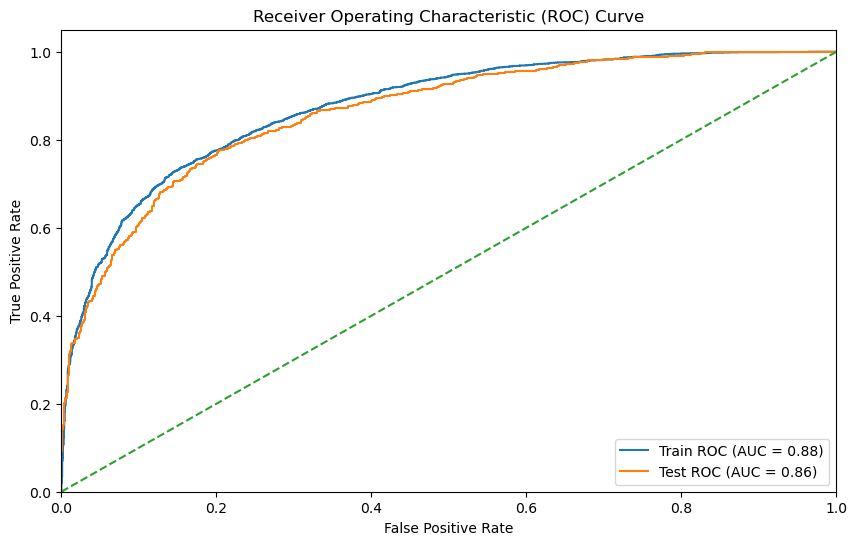

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 8s 998us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 8s 979us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 811us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 7s 931us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 7s 870us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 7s 957us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 8s 979us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 7s 879us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 6s 805us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 7s 853us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
7657/7657 ━━━━━━━━━━━━━━━━━━━━ 7s 934us/step
1/1 ━━━━

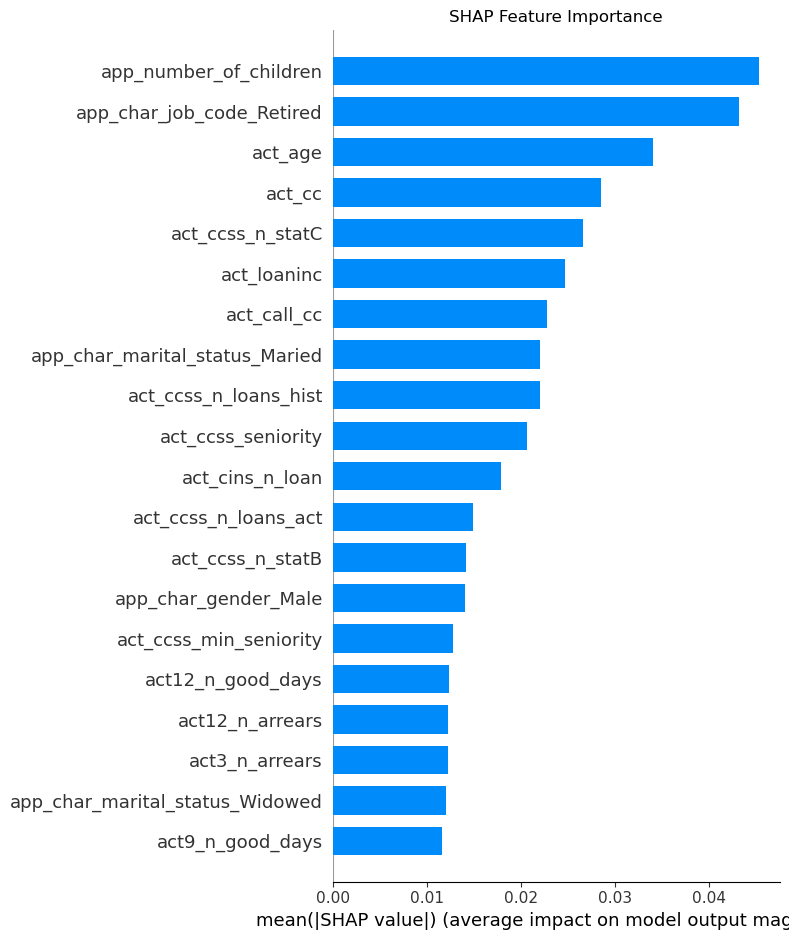


Top 10 features by SHAP importance:
                            feature  importance
6            app_number_of_children    0.045266
197       app_char_job_code_Retired    0.043126
0                           act_age    0.034000
1                            act_cc    0.028483
28                 act_ccss_n_statC    0.026613
2                       act_loaninc    0.024723
9                       act_call_cc    0.022830
198  app_char_marital_status_Maried    0.022038
27            act_ccss_n_loans_hist    0.022033
25               act_ccss_seniority    0.020685
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


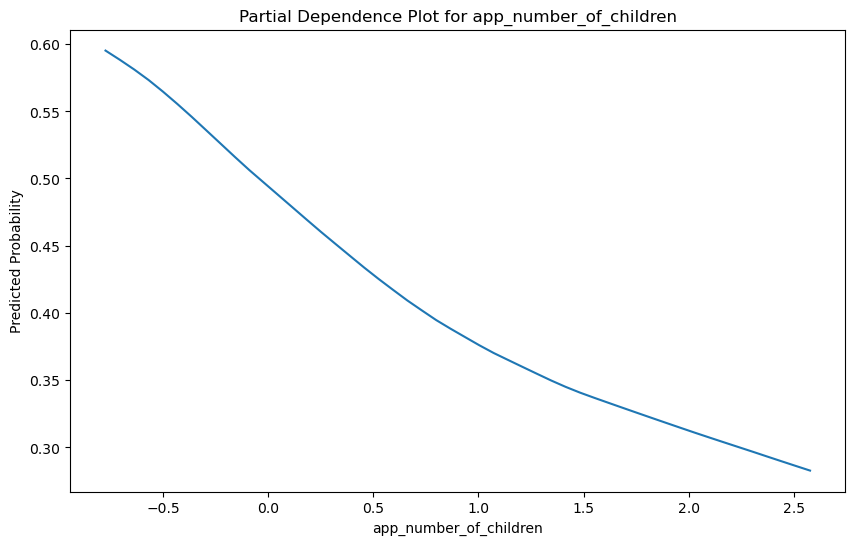

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


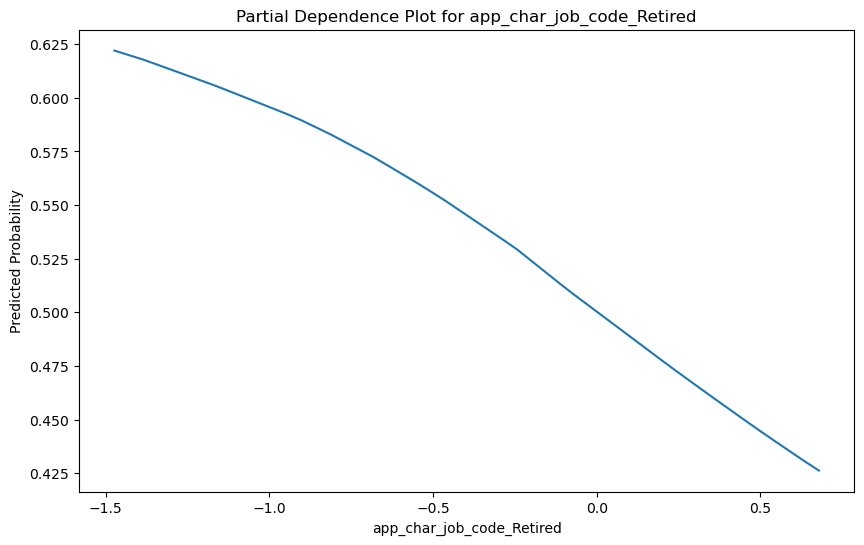

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


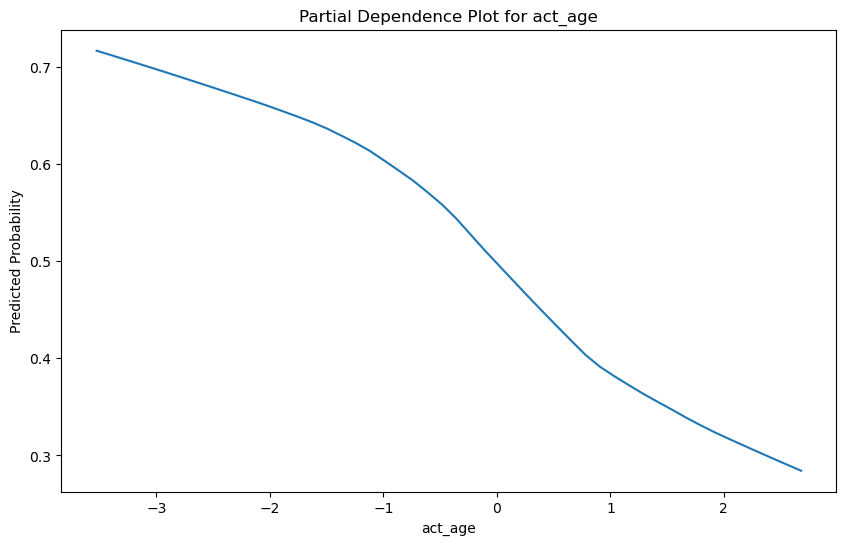

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


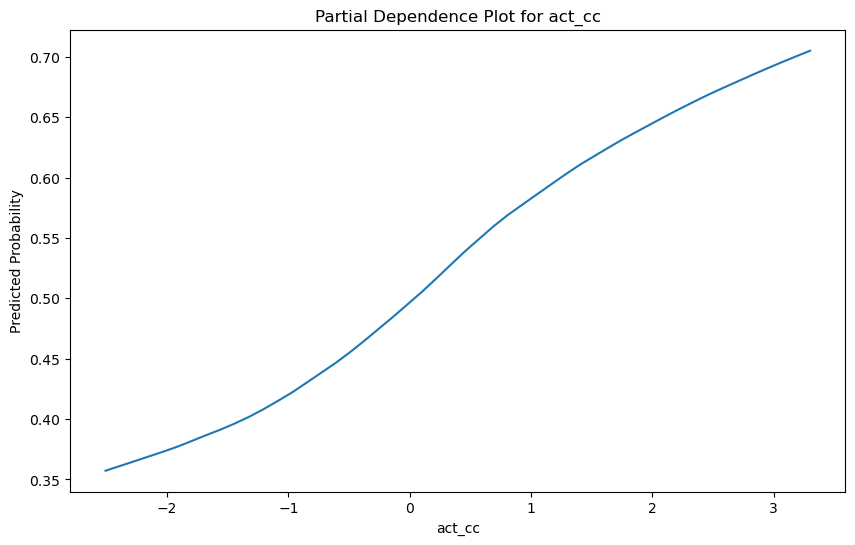

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


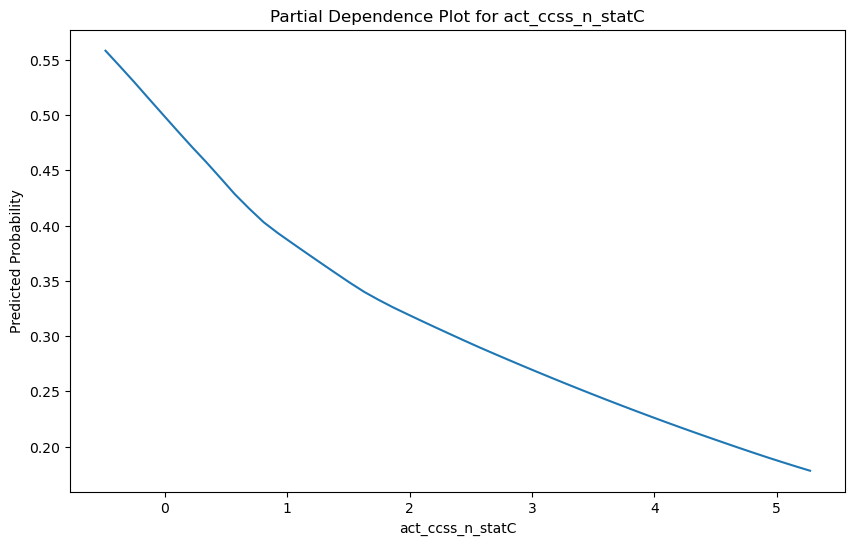

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


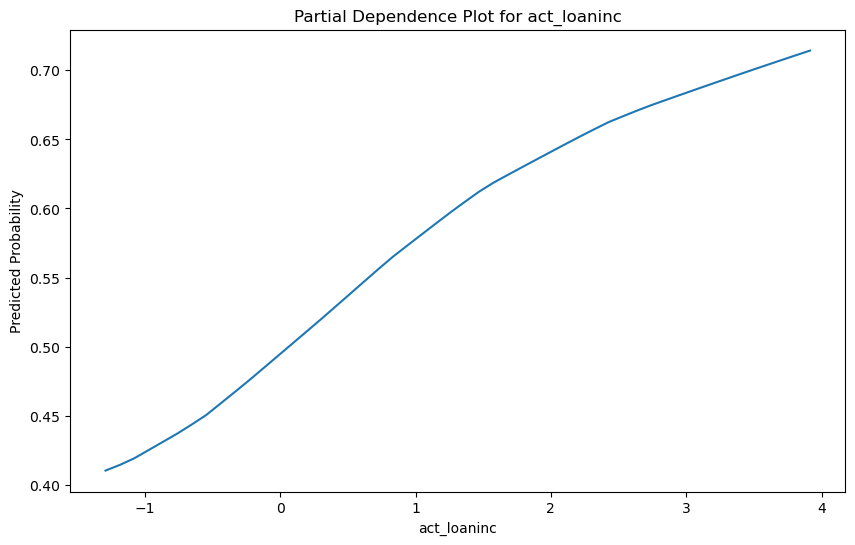

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


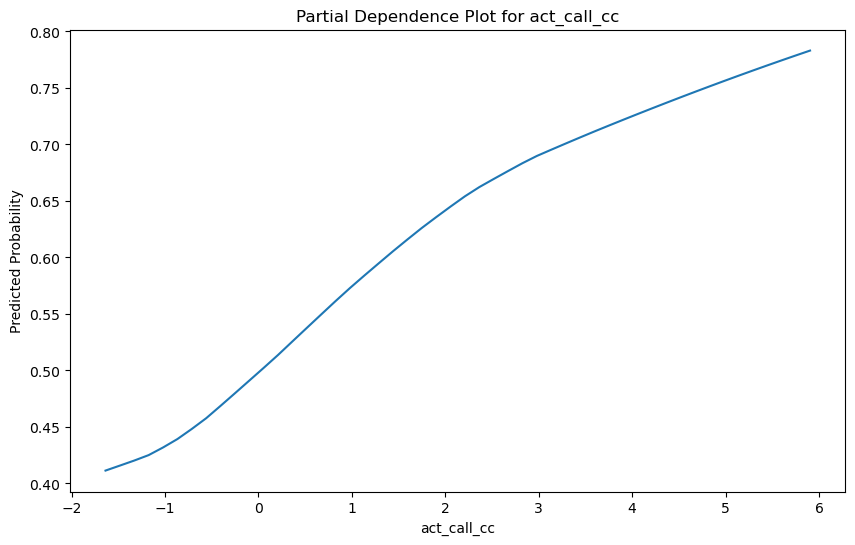

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


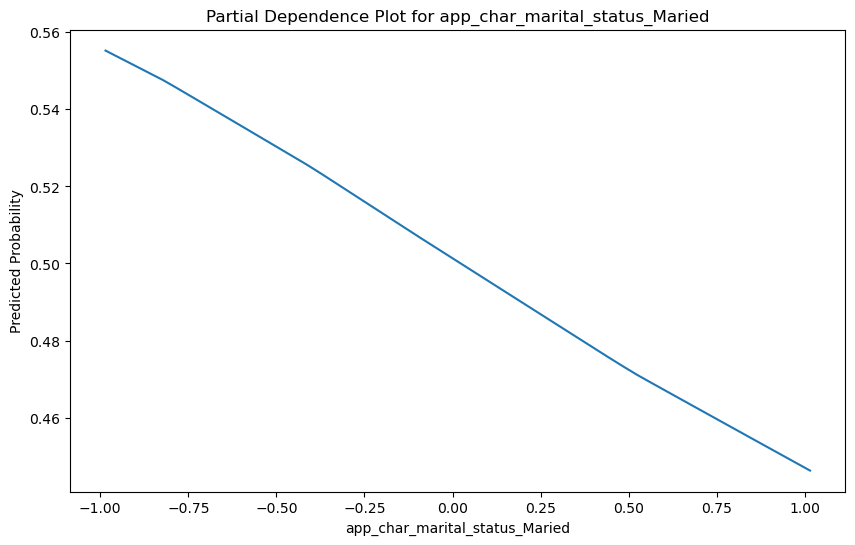

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


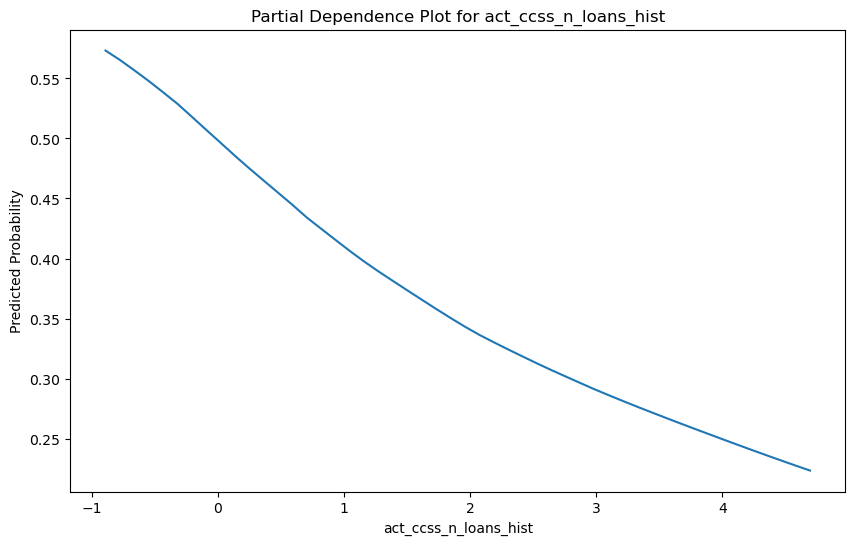

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


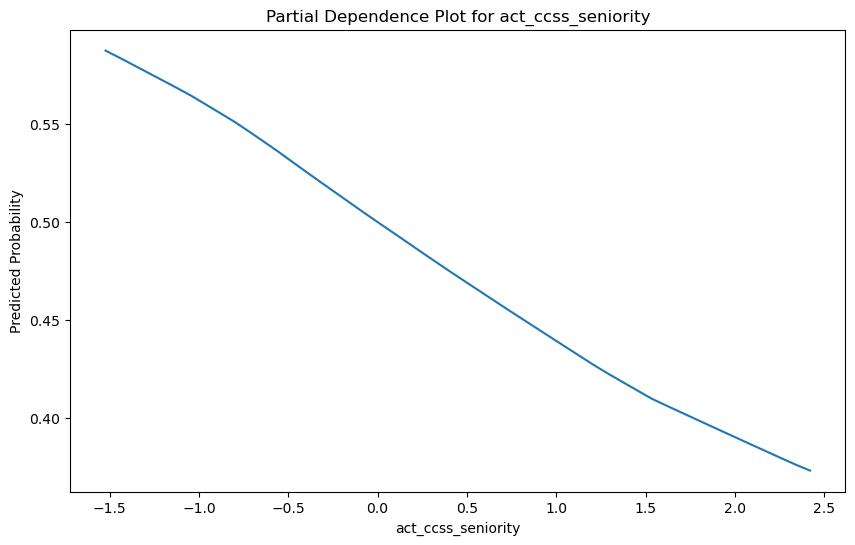

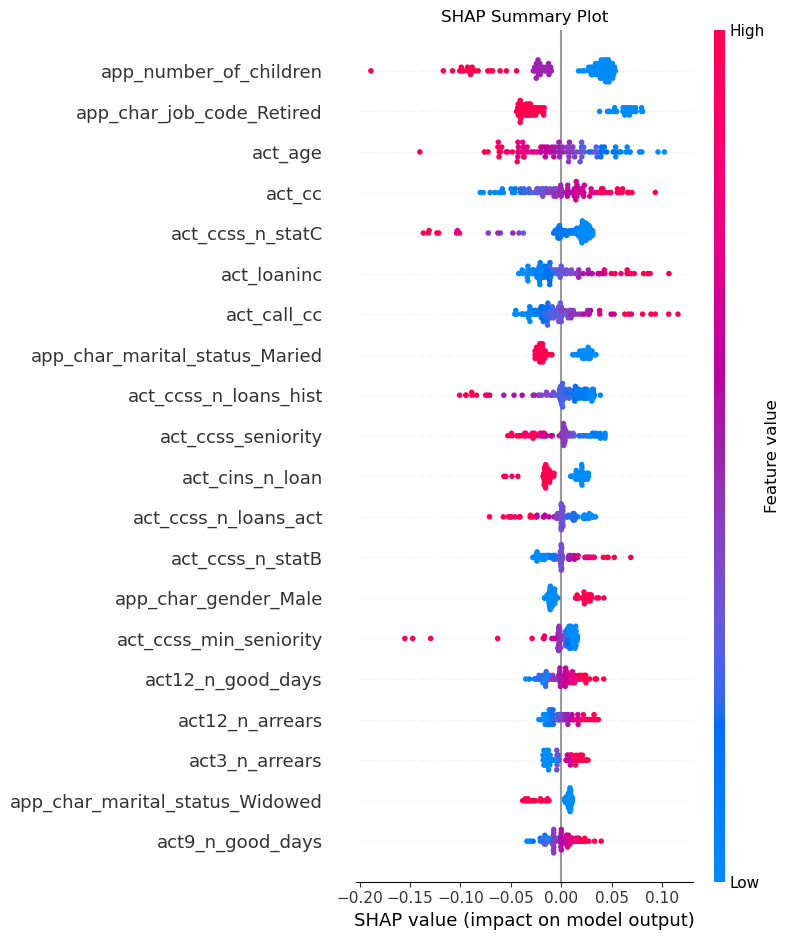

<Figure size 1000x600 with 0 Axes>

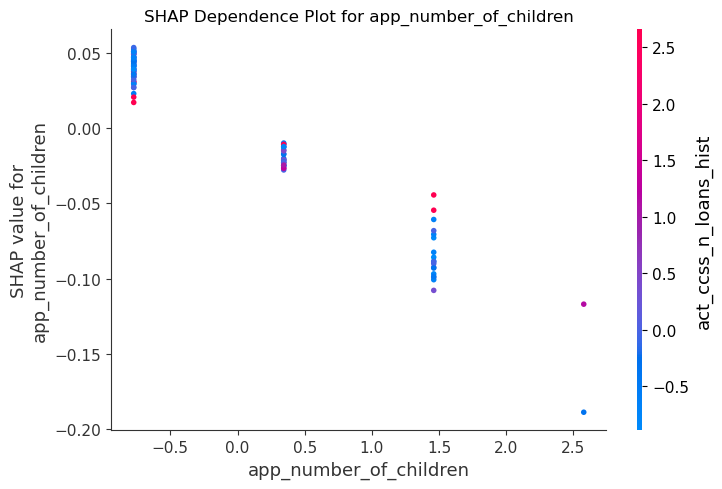

<Figure size 1000x600 with 0 Axes>

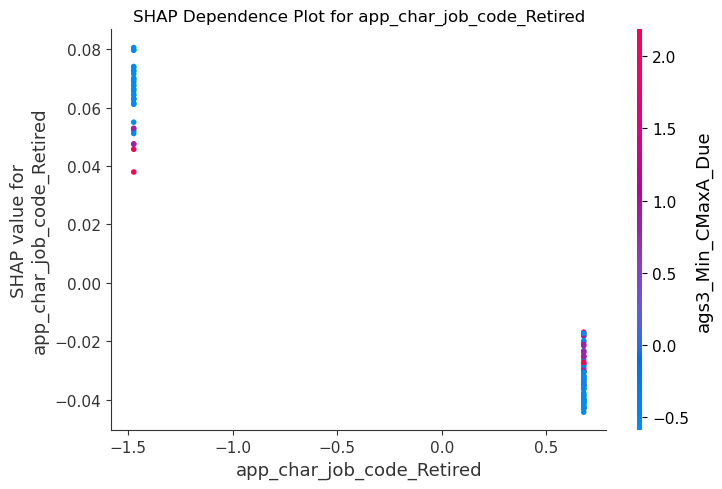

<Figure size 1000x600 with 0 Axes>

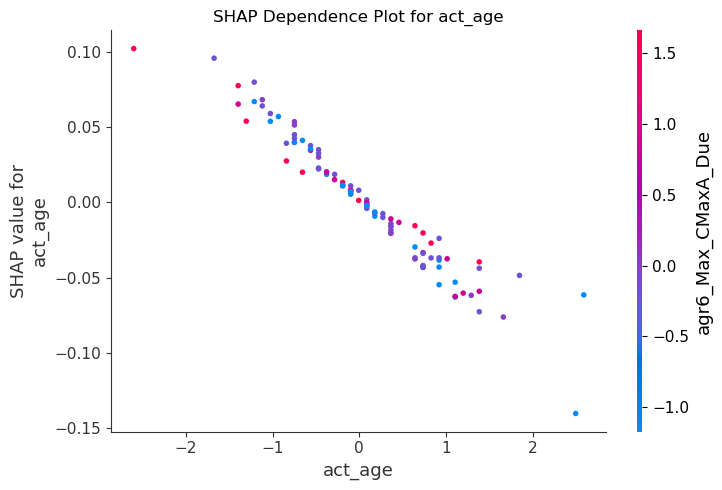

<Figure size 1000x600 with 0 Axes>

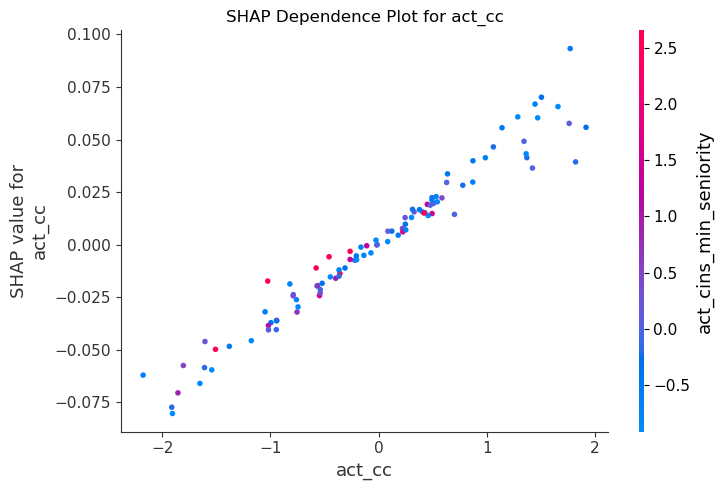

<Figure size 1000x600 with 0 Axes>

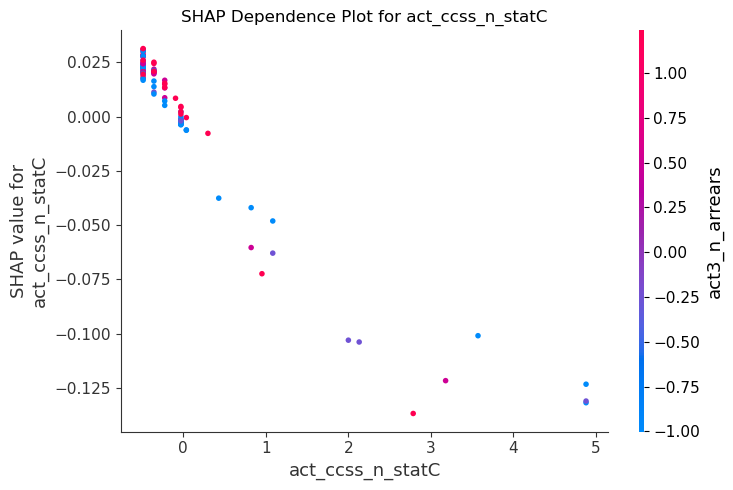

<Figure size 1000x600 with 0 Axes>

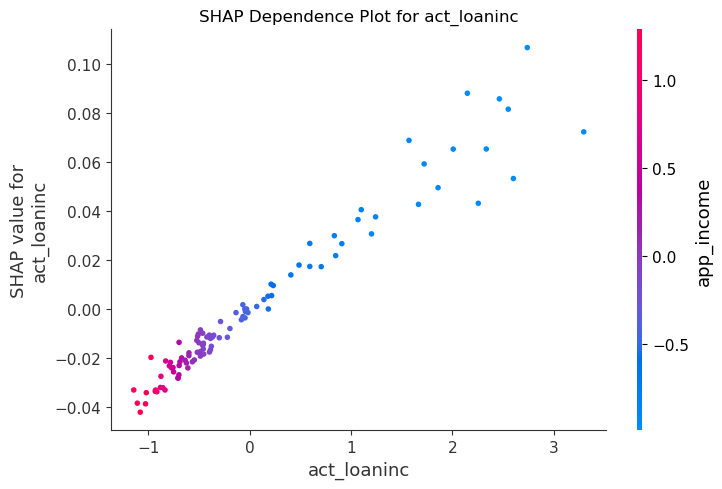

<Figure size 1000x600 with 0 Axes>

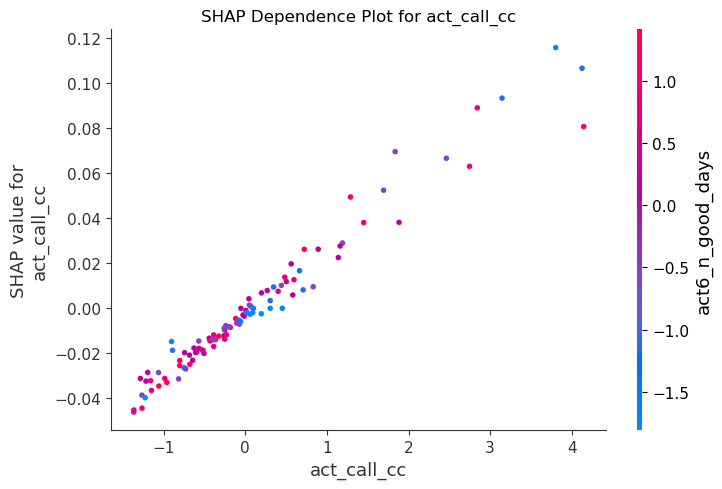

<Figure size 1000x600 with 0 Axes>

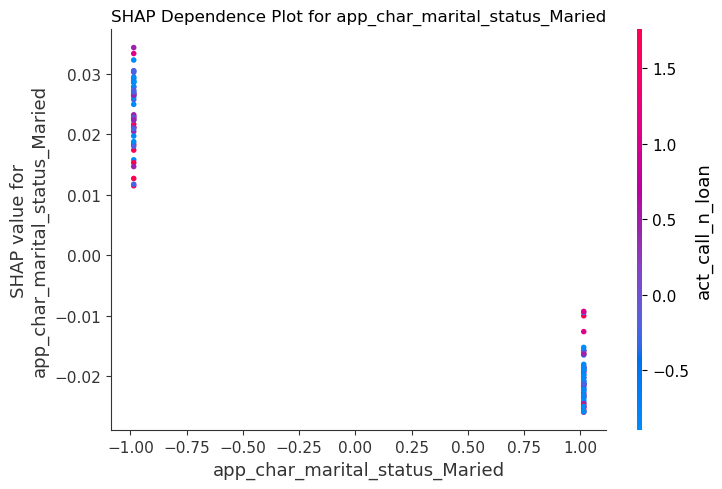

<Figure size 1000x600 with 0 Axes>

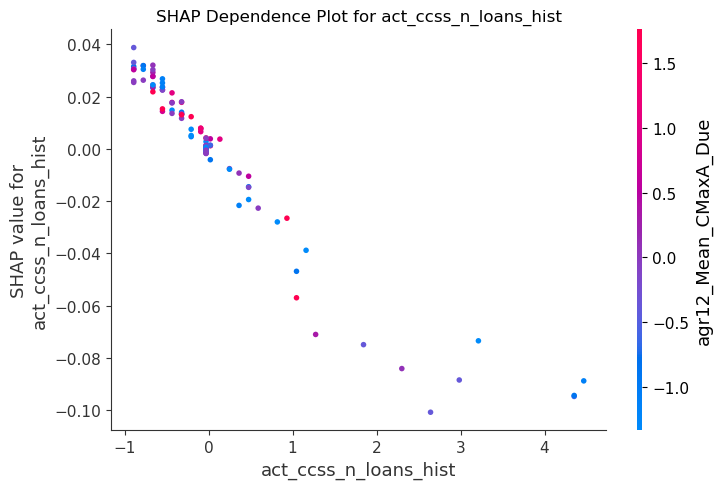

<Figure size 1000x600 with 0 Axes>

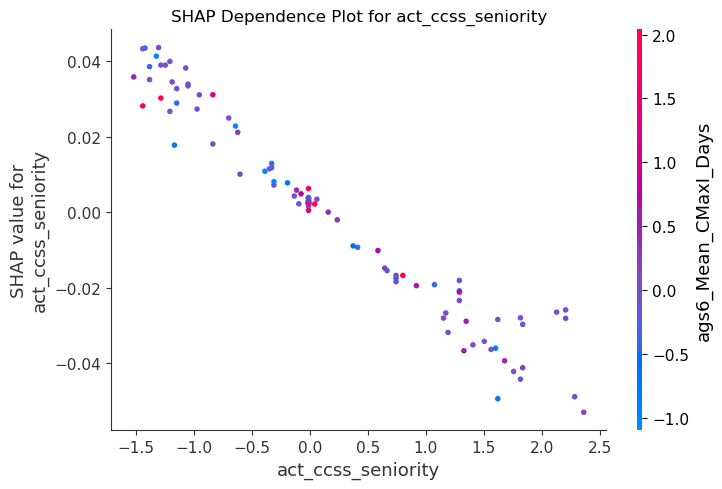

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, roc_curve

# 1. Load and Preprocess Data
def load_and_preprocess_data(file_path):
    df = pd.read_sas(file_path, encoding='LATIN2')
    df = df[('197501' <= df['period']) & (df['period'] <= '198712') & (df['product'] == 'css') & (df['decision'] == 'A')]
    
    features = [col for col in df.columns if col.startswith(('app', 'act', 'agr', 'ags'))]
    X = df[features]
    y = df['default12']
    
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(drop='first', sparse_output=False))
            ]), categorical_features)
        ])
    
    X_processed = preprocessor.fit_transform(X)
    feature_names = (list(numeric_features) + 
                     list(preprocessor.named_transformers_['cat']
                          .named_steps['onehot']
                          .get_feature_names_out(categorical_features)))
    
    X_processed = pd.DataFrame(X_processed, columns=feature_names)
    
    mask = ~y.isna()
    X_processed = X_processed[mask]
    y = y[mask]
    
    return X_processed, y

# 2. Build and Train Model
def build_and_train_model(X_train, y_train, X_val, y_val):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                        epochs=5, batch_size=64, callbacks=[early_stopping], verbose=1)
    
    return model, history

# 3. Evaluate Model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()
    
    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)
    
    train_gini = 2 * train_auc - 1
    test_gini = 2 * test_auc - 1
    
    print(f"Train AUC: {train_auc:.4f}, Train Gini: {train_gini:.4f}")
    print(f"Test AUC: {test_auc:.4f}, Test Gini: {test_gini:.4f}")
    
    # Manual cross-validation for Keras model
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    
    # Convert to numpy arrays if they're not already
    X_train_array = X_train if isinstance(X_train, np.ndarray) else X_train.values
    y_train_array = y_train if isinstance(y_train, np.ndarray) else y_train.values
    
    for train_index, val_index in cv.split(X_train_array):
        X_train_cv, X_val_cv = X_train_array[train_index], X_train_array[val_index]
        y_train_cv, y_val_cv = y_train_array[train_index], y_train_array[val_index]
        
        model_cv, _ = build_and_train_model(X_train_cv, y_train_cv, X_val_cv, y_val_cv)
        
        y_val_pred_cv = model_cv.predict(X_val_cv).flatten()
        cv_scores.append(roc_auc_score(y_val_cv, y_val_pred_cv))
    
    print(f"Cross-validation ROC AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")
    
    return y_train_pred, y_test_pred

# 4. Plot ROC Curve
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_pred):.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_pred):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# 5. Feature Importance Analysis and SHAP Values Calculation
def analyze_feature_importance(model, X, feature_names):
    # Use a wrapper function that outputs probabilities
    f = lambda x: model.predict(x).flatten()
    
    # Use a smaller sample size for faster computation
    X_sample = shap.sample(X, 100)
    
    # Create the explainer
    explainer = shap.KernelExplainer(f, X_sample)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample)
    
    # Create the summary plot
    shap.summary_plot(shap_values, X_sample, plot_type="bar", feature_names=feature_names, show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(shap_values).mean(0)
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 features by SHAP importance:")
    print(feature_importance.head(10))
    
    return feature_importance, shap_values, X_sample

# 6. Partial Dependence Plots
def plot_partial_dependence(model, X, feature_names, features):
    for feature in features:
        if feature not in feature_names:
            print(f"Warning: Feature '{feature}' not found in the dataset. Skipping.")
            continue
        
        feature_idx = list(feature_names).index(feature)
        
        # Create a range of values for the feature
        feature_values = np.linspace(X[:, feature_idx].min(), X[:, feature_idx].max(), num=50)
        
        # Create copies of X with different values for the feature
        X_plot = np.repeat(X.mean(axis=0).reshape(1, -1), len(feature_values), axis=0)
        X_plot[:, feature_idx] = feature_values
        
        # Get predictions
        y_plot = model.predict(X_plot).flatten()
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.plot(feature_values, y_plot)
        plt.xlabel(feature)
        plt.ylabel('Predicted Probability')
        plt.title(f'Partial Dependence Plot for {feature}')
        plt.show()

# 7. SHAP Summary Plot
def plot_shap_summary(shap_values, X_sample, feature_names):
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample, plot_type="dot", feature_names=feature_names, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()

# 8. SHAP Dependence Plot
def plot_shap_dependence(shap_values, X_sample, feature_names, feature_to_plot):
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(feature_to_plot, shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title(f"SHAP Dependence Plot for {feature_to_plot}")
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    file_path = 'C:/Users/khtur/Desktop/Eas/Models/abt_app.sas7bdat'
    X, y = load_and_preprocess_data(file_path)
    
    # Use a smaller subset of data
    X = X.sample(n=min(10000, len(X)), random_state=42)
    y = y.loc[X.index]
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    # Store original feature names
    feature_names = X.columns.tolist()
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    model, history = build_and_train_model(X_train_scaled, y_train, X_val_scaled, y_val)
    
    y_train_pred, y_test_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test)
    
    plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)
    
    feature_importance, shap_values, X_sample = analyze_feature_importance(model, X_test_scaled, feature_names)
    
    top_features = feature_importance['feature'].head(10).tolist()
    plot_partial_dependence(model, X_test_scaled, feature_names, top_features)
    
    # Additional SHAP visualizations
    plot_shap_summary(shap_values, X_sample, feature_names)
    
    # Plot SHAP dependence for the top 10 features
    for feature in top_features:
        plot_shap_dependence(shap_values, X_sample, feature_names, feature)